In [1]:
# Tool importing section
import os #related to file directory
import earthpy as et # not in use
import earthpy.plot as ep # plotting histogram
import earthpy.spatial as es # used for cropping raster
import fiona
from glob import glob #identifying files within path
import geopandas as gpd #reading files - vector
import numpy as np #used for masking rasters
import numpy.ma as ma #used for masking rasters
import matplotlib.pyplot as plt #plotting data
import matplotlib.lines as mlines #dissolve
from osgeo import gdal,ogr #used to convert raster to shp
import pandas as pd
import pathlib #related to file directory
from pathlib import Path #related to file directory
import rasterio as rio #reading files - raster
from rasterio.merge import merge #mosaic rasters
from rasterio.plot import show #plotting mosaic raster
from rasterio.features import shapes #create vector from raster
from rasterio.warp import calculate_default_transform, reproject, Resampling #projecting rasters
from rasterio.plot import plotting_extent #set extent after cropping
import richdem as rd #open raster for slope calculations
from shapely.geometry import Polygon #clip vector
from shapely.geometry import shape #vector from raster process
import sys #gdal error message

In [2]:
#Set Highest level folder
os.chdir(os.path.join('P:\\Personal Files\\Education\\FRCC\\NSF_Internship\\NSF_Project_Files\\Data'))
#Set variables
projection = "epsg:26914"
landuse_mosaic_outpath = os.path.join("Landuse_Results","landuse_mosaic.tif")
landuse_mosaic_crop_outpath = os.path.join("Landuse_Results","landuse_mosaic_crop.tif")
landuse_outpath = os.path.join("Landuse_Results","landuse.tif")
landuse_rc_outpath = os.path.join("Landuse_Results","landuse_reclass.tif")
poly_landuse = os.path.join("Landuse_Results","landuse_reclass_poly.shp")
table_org=os.path.join("Preped_CSVs","GAP_LANDFIRE_Attributes_with_CN.csv")
final_landuse = os.path.join("Final_Results","Input_Layers","Landuse_CN_Groups.shp")
landuse_fig = os.path.join("Figures","Reservation_Landuse.png")
join_head=['raster_val','CN-A','CN-B','CN-C','CN-D','geometry']
LU_dis = os.path.join("Landuse_Results","Landuse_diss.shp")

In [3]:
#Set Reservation boundary
res_field = "LARName" #field name where reservation name is found
res_name = "Standing Rock LAR" #name of the reservation from the shape file
res_path = os.path.join("Reservation_Boundary_Layer","BIA_National_LAR.shp")
res_boundary = gpd.read_file(res_path)
res_aoi = res_boundary[res_boundary[res_field] == res_name]
res_projected = res_aoi.to_crs(projection)

In [ ]:
#Access landuse
landuse_path = os.path.join("Landuse_Original_Data")
all_landuse = glob(os.path.join(landuse_path, "*.tif"))
all_landuse.sort()
#Set Reprojected landuse folder
reproj_landuse_fold = os.path.join("Landuse_Results","Landuse_Projection")

In [ ]:
#Start of the applying Projection Area

In [ ]:
#Change Projections to match
def reproject_et(inpath, outpath, new_crs):
    dst_crs = new_crs #new projection

    with rio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [ ]:
for ned in all_landuse:
    reproject_et(inpath = os.path.join(ned), 
                 outpath = os.path.join(reproj_landuse_fold,os.path.basename(ned)), 
                 new_crs = projection)

In [ ]:
projected_landuse_path = glob(os.path.join(reproj_landuse_fold,"*.tif"))

In [ ]:
#End of the applying Projection Area

In [ ]:
#Start of Merging (Mosaic) and Masking Rasters

In [ ]:
landuse_to_mosaic = []
#Open Rasters
for ned in projected_landuse_path:
    src = rio.open(ned)
    landuse_to_mosaic.append(src)

In [ ]:
landuse_mosaic, landuse_out_trans = merge(landuse_to_mosaic)

In [ ]:
with rio.open(projected_landuse_path[0]) as src:
    landuse_data = src.read()
    landuse_meta = src.profile
    
landuse_meta

In [ ]:
landuse_width_meta = landuse_mosaic.shape[2]
landuse_height_meta = landuse_mosaic.shape[1]

In [ ]:
landuse_meta['width'] = landuse_width_meta
landuse_meta['height'] = landuse_height_meta
landuse_meta['transform'] = landuse_out_trans
landuse_meta

In [ ]:
for raster in landuse_to_mosaic:
    raster.close()

In [ ]:
mask_landuse_mosaic = np.where(landuse_mosaic < 0, True, False)
masked_landuse_mosaic = np.ma.masked_array(landuse_mosaic, mask_landuse_mosaic)
#ep.hist(masked)

In [ ]:
#End of Merging (Mosaic) and Masking Rasters

In [ ]:
#Converting Mosaic Numpy to a GeoTiff and Cropping

In [ ]:
sqz_landuse_mosaic = masked_landuse_mosaic.squeeze()

In [ ]:
# Write raster object to folder
with rio.open(landuse_mosaic_outpath, 'w', **landuse_meta) as dst:
    dst.write(sqz_landuse_mosaic, 1)

In [ ]:
#clearing out nolonger needed data.
del landuse_mosaic
del landuse_out_trans
del projected_landuse_path
del mask_landuse_mosaic
del masked_landuse_mosaic
del sqz_landuse_mosaic

In [ ]:
with rio.open(landuse_mosaic_outpath) as landuse_src:

    # Crop raster data to boundary
    landuse_data_crop, landuse_meta_crop = es.crop_image(
        landuse_src, res_projected)

# Define plotting extent using cropped array and transform from metadata
landuse_crop_plot_extent = plotting_extent(
    landuse_data_crop[0], landuse_meta_crop["transform"])

In [ ]:
f, ax = plt.subplots()

ep.plot_bands(landuse_data_crop,
              ax=ax,
              title="Check that cropped landuse line up with Reservation Shapefile",
              scale=False,
              cmap="gray",
              extent=landuse_crop_plot_extent)  # Use plotting extent from cropped array

res_projected.plot(color='None',
                    edgecolor='teal',
                    linewidth=2,
                        ax=ax)

plt.show()

In [ ]:
sqz_landuse_data_crop = landuse_data_crop.squeeze()
with rio.open(landuse_mosaic_crop_outpath, 'w', **landuse_meta_crop) as dst:
    dst.write(sqz_landuse_data_crop, 1)

In [ ]:
#End of Converting Mosaic Numpy to a GeoTiff and Cropping

In [ ]:
#clearing out old data round 2
del landuse_mosaic_outpath
del landuse_data_crop
del sqz_landuse_data_crop

In [ ]:
#Convert Reclassified Grid into vector

In [ ]:
mask = None
with rio.Env():
    with rio.open(landuse_mosaic_crop_outpath) as src:
        image = src.read(1) # first band
        #print(src.crs)
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.transform)))

In [ ]:
geoms = list(results)
#print (geoms)

In [ ]:
#print (shape(geoms[0]['geometry']))

In [ ]:
gpd_polygonized_raster = gpd.GeoDataFrame.from_features(geoms,crs=projection)
gpd_polygonized_raster.to_file(poly_landuse)

In [ ]:
#End of Convert Reclassified Grid into vector

In [ ]:
#clearing out old data round 3

In [ ]:
del landuse_mosaic_crop_outpath
del geoms
del gpd_polygonized_raster

In [ ]:
landuse_poly = gpd.read_file(poly_landuse)
landuse_poly.head()
landuse_value = landuse_poly[['raster_val','geometry']]
landuse_dissolve = landuse_value.dissolve(by='raster_val')
landuse_dissolve

In [ ]:
landuse_dissolve.to_file(LU_dis)

In [ ]:
landuse_buffer = landuse_dissolve.buffer(0)

In [ ]:
landuse_poly_clip = gpd.clip(landuse_buffer,res_projected)

In [ ]:
landuse_poly_clip=landuse_poly_clip.reset_index(0)

In [ ]:
column_names = list(landuse_poly_clip)
print(column_names)
landuse_poly_clip.head()

In [ ]:
f, ax1 = plt.subplots()
landuse_poly_clip.plot(ax=ax1)
ax1.set(title="Land Use")
plt.show()
#plt.savefig()

In [ ]:
#Joining with table

In [ ]:
column_names = list(landuse_poly_clip)
column_names
landuse_poly_clip.head()

In [ ]:
table_r = pd.read_csv(table_org)
landuse_poly_clip['raster_val']=landuse_poly_clip.raster_val.astype(int)
table_r['Value']=table_r.Value.astype(int)
table_r.rename(columns={'Value':'raster_val'},inplace=True)
table_r.head()

In [ ]:
landuse_join = landuse_poly_clip.merge(table_r, on='raster_val', how='outer')
landuse_join.head()

In [ ]:
column_names = list(landuse_join)
column_names

In [ ]:
landuse_join_reduced = landuse_join[join_head]
column_names2 = list(landuse_join_reduced)
print(column_names2)
print(landuse_join_reduced.head())

In [4]:
LU_Arc = os.path.join("ArcGIS","landuse_CN_join.shp")
landuse_join_reduced = gpd.read_file(LU_Arc)

P:\My_Programs\miniconda\envs\earth-analytics-python\lib\site-packages\geopandas\plotting.py:146: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


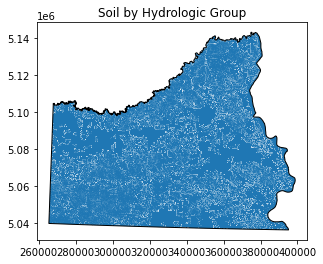

<Figure size 432x288 with 0 Axes>

In [5]:
f, ax1 = plt.subplots()
landuse_join_reduced.plot(legend=True,
               ax=ax1)
res_projected.plot(color='None',
            Edgecolor='black',ax=ax1)
ax1.set(title="Soil by Hydrologic Group")
plt.show()
plt.draw()
f.savefig(landuse_fig, dpi=400)

In [ ]:
#Save File
landuse_join_reduced.to_file(final_landuse)

In [ ]:
#End of landuse Prep